In [2]:
from pathlib import Path

import pandas as pd 
import numpy as np
import xarray as xr
import geopandas as gpd 
from shapely import box
import pycountry

from tqdm.notebook import tqdm

import config.config as cfg 
from config.config import (PROCESSED_GMT_FILE,
                           GRAPHICS_DIR, GRAPHICS_PAPER_MAIN_DIR, GRAPHICS_PAPER_APPENDIX_DIR, 
                           RESULTS_DIR,
                           fontsize_medium,
                           fontsize_small,
                           fontsize_large, 
                           regions,
                           region_naming_dict, 
                           population_shares, 
                           group_colors,
                           uncertainty_color,
                           sensitvitiy_color,
                           symbols,
                           EU27_ids
                           )
from utils.plotting_functions import lighten_color

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colormaps as cmaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.colors as cm

from itertools import product

plt.rcParams['svg.fonttype'] = 'none'

In [4]:
tas_frequency_df = xr.open_dataset(RESULTS_DIR / 'tas_frequency_hot.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
spei_frequency_df = xr.open_dataset(RESULTS_DIR / 'spei_frequency_dry.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
tas_intensity_df = xr.open_dataset(RESULTS_DIR / 'tas_intensity_hot.nc').stack(coords = ('lat', 'lon')).dropna('coords', how = 'all')
# some spei values are nan but we want to keep them
spei_intensity_df = xr.open_dataset(RESULTS_DIR / 'spei_intensity_dry.nc').stack(coords = ('lat', 'lon')).sel(coords = tas_intensity_df['coords'])
spi_intensity_df = xr.open_dataset(RESULTS_DIR / 'spi_intensity_dry.nc').stack(coords = ('lat', 'lon')).sel(coords = tas_intensity_df['coords'])

In [9]:

import regionmask 

# selecting regions
ar6 = regionmask.defined_regions.ar6.land

def blend_colors(c1, c2, weight=0.5):
    """
    Blend two colors c1 and c2 based on the weight. 
    The weight controls the influence of each color.
    """
    # Extract RGB components
    r1, g1, b1, _ = c1
    r2, g2, b2, _ = c2
    
    # Blend the RGB channels separately
    blended_r = r1 * (1 - weight) + r2 * weight
    blended_g = g1 * (1 - weight) + g2 * weight
    blended_b = b1 * (1 - weight) + b2 * weight
    
    # Return the blended color with full alpha (1.0)
    return np.array([blended_r, blended_g, blended_b, 1.0])   

def digitize_with_nan(arr, bins):
    """Digitize an array, keeping NaN values intact."""
    # Create a masked array for NaN values
    arr_masked = np.ma.masked_array(arr, np.isnan(arr))
    
    # Digitize the masked array
    digitized = np.digitize(arr_masked, bins)
    
    # Convert the masked array back to regular array and set NaNs
    return np.where(np.isnan(arr), np.nan, digitized)
    
def color_palette_2D(tas_bins = [1, 5, 10, 20, 30], spei_bins = [1, 5, 10, 20, 30]):
    N_bins = len(tas_bins) + 1
    
    Blues = LinearSegmentedColormap.from_list("", ["#ffffff", "#0000ff"], gamma=0.8)
    Reds  = LinearSegmentedColormap.from_list("", ["#ffffff", "#ff0000"], gamma=0.8)
    cmap_a = Blues(np.linspace(0, 1, N_bins))
    cmap_b = Reds(np.linspace(0, 1, N_bins))

    cmap_mix = [blend_colors(cmap_a[i], cmap_b[j], 0.5) for i, j in product(np.arange(N_bins), np.arange(N_bins))]

    return(cmap_mix)

def color_palette_2D_plot(ax, tas_bins = [1, 5, 10, 20, 30], spei_bins = [1, 5, 10, 20, 30], tas_bin_labels = [1, 5, 10, 20, '30+'], spei_bin_labels = [1, 5, 10, 20, '30+']):
    N_bins = len(tas_bins) + 1
     
    cmap_mix = color_palette_2D(tas_bins, spei_bins)

    ax.imshow(np.array(cmap_mix).reshape(-1,N_bins,4), extent=[0, 1, 0, 1], origin='lower')
    ax.set_title("Intensity increase", fontsize = fontsize_large)
    ax.set_xlabel('Temperature [°C]', fontsize = fontsize_medium)
    ax.set_ylabel('SPEI [-]', fontsize = fontsize_medium)
    ax.set_xticks(np.linspace(0,1,N_bins+1)[:-1]) 
    ax.set_xticklabels([0] + tas_bin_labels,
                        fontsize = fontsize_medium)
    ax.set_yticks(np.linspace(0,1,N_bins+1)[:-1])
    ax.set_yticklabels([0] + spei_bin_labels, 
                        fontsize = fontsize_medium)
    
    return()

def data_2D_map(i_quantile, m, tas_bins = [1, 5, 10, 20, 30], spei_bins = [1, 5, 10, 20, 30]):
    # --- Binned map data ---
    # Bin the values of df_attribution
    tas_attribution_binned = xr.apply_ufunc(
        digitize_with_nan,
        tas_intensity_df['attributed_tas'].isel(region = 0, group = 0, extreme_quantile = i_quantile, month = m).mean(dim = 'model'), 
        tas_bins, dask="allowed"
    ) 

    # Bin the values of spei_df_attribution
    spei_attribution_binned = xr.apply_ufunc(
        digitize_with_nan, 
        -spi_intensity_df['attributed_spi'].isel(region = 0, group = 0,  extreme_quantile = i_quantile, month = m).mean(dim = 'model'), 
        spei_bins, dask="allowed"
    )

    combined_values = (tas_attribution_binned) + (spei_attribution_binned)*5

    # Create a new DataArray for the combined values
    combined_df = xr.DataArray(
        combined_values,
        dims = ["coords"],
        coords = {"coords": tas_frequency_df['coords']},
        name = "combined_attribution"
    ).unstack('coords').sortby('lon')
    
    del tas_attribution_binned, spei_attribution_binned, combined_values
    
    lons = combined_df['lon'].values
    lats = combined_df['lat'].values

    tas_z_mean = tas_intensity_df['attributed_tas'].isel(region = 0, group = 0, extreme_quantile = i_quantile, month = m).mean(dim = 'model').unstack('coords').sortby('lon').values.T
    tas_z_std = tas_intensity_df['attributed_tas'].isel(region = 0, group = 0, extreme_quantile = i_quantile, month = m).std(dim = 'model').unstack('coords').sortby('lon').values.T
    tas_z_mean[np.isnan(tas_z_mean)] = 1000
    tas_z_std[np.isnan(tas_z_std)] = 0
    
    spei_z_mean = np.abs(spi_intensity_df['attributed_spi'].isel(region = 0, group = 0, extreme_quantile = i_quantile, month = m).mean(dim = 'model').unstack('coords').sortby('lon').values.T)
    spei_z_std = spi_intensity_df['attributed_spi'].isel(region = 0, group = 0, extreme_quantile = i_quantile, month = m).std(dim = 'model').unstack('coords').sortby('lon').values.T
    spei_z_mean[np.isnan(spei_z_mean)] = 1000
    spei_z_std[np.isnan(spei_z_std)] = 0    
    return(combined_df, tas_z_mean, tas_z_std, spei_z_mean, spei_z_std, lons, lats)

def plot_2D_map(i_quantile, m, m_name, ax, sel_regions, tas_bins = [1, 5, 10, 20, 30], spei_bins = [1, 5, 10, 20, 30], tas_bin_labels = [1, 5, 10, 20, '30+'], spei_bin_labels = [1, 5, 10, 20, '30+']):
    density = 3

    gdf = ar6.to_geodataframe()
    gdf = gdf.set_index("abbrevs")

    # cbar data
    N_bins = len(tas_bins) + 1
    cmap_mix = color_palette_2D(tas_bins = tas_bins, spei_bins = spei_bins)
    cmap_2D = LinearSegmentedColormap.from_list('2D', cmap_mix, N=N_bins**2)
    # map data
    combined_df, tas_z_mean, tas_z_std, spei_z_mean, spei_z_std, lons, lats = data_2D_map(i_quantile, m, tas_bins = tas_bins, spei_bins = spei_bins)

    ax.set_global()
    ax.coastlines(edgecolor = 'lightgrey')

    ax.contourf(
        lons, lats, (tas_z_mean.T < tas_z_std.T)*1,
        transform = ccrs.PlateCarree(),
        colors = 'none',
        levels=[.5,1.5],
        hatches=[density*'|',density*'|'], 
        zorder = 10
    )

    ax.contourf(
        lons, lats, (spei_z_mean.T < spei_z_std.T)*1,
        transform = ccrs.PlateCarree(),
        colors = 'none',
        levels=[.5,1.5],
        hatches=[density*'-',density*'-'],
        zorder = 10
    )    

    combined_df.plot(ax=ax, 
                    transform = ccrs.PlateCarree(),
                    cmap = cmap_2D,
                    levels  = np.arange(N_bins**2),
                    add_colorbar = False,
                    extend = 'neither',
                    alpha = None)
    
    for abbrev in [ar6[region].abbrev for region in sel_regions]: 
        gdf.loc[[abbrev]].plot(ax=ax, transform=ccrs.PlateCarree(), 
                            facecolor='none', 
                            edgecolor = 'black', 
                            lw = 1.5)

    ax.set_title(f'Intensity change of 1-in-100 year extremes in {m_name} attributed to global top 10$\%$', fontsize = fontsize_large)
    return()

def data_for_boxplot(dfs, sel_vars):
    boxplot_data_combined = []
    mean_values_combined = []
    for i_var, df in enumerate(dfs):
        boxplot_data = df[sel_vars[i_var]].isel(region = 0, group = 0, extreme_quantile = 1).median('model').values
        if i_var == 1: 
            boxplot_data *= -1
        boxplot_data_combined.append(boxplot_data)
        mean_values_tmp = np.nanmean(boxplot_data, axis = 1)
        mean_values_combined.append((mean_values_tmp-mean_values_tmp.min())/ (mean_values_tmp.max()-mean_values_tmp.min()))
    return(boxplot_data_combined, mean_values_combined)

def boxplot(dfs, sel_vars, axes, titles = ['', ''], yticks_multi = [[0,10,20,30], [0,10,20,30]], yticklabels_multi = [[0,10,20,30], [0,10,20,30]]):
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    Blues = LinearSegmentedColormap.from_list("", ["#e5e5ff", '#ccccff', '#b2b2ff', '#9999ff', '#7f7fff', '#6666ff'], gamma=0.8)
    Reds  = LinearSegmentedColormap.from_list("", ["#ffe5e5", '#ffcccc', '#ffb2b2', '#ff9999', '#ff7f7f', "#ff6666"], gamma=0.8)
    
    colormaps = [Reds, Blues]
    width = 0.8
    
    boxplot_data_combined, mean_values_combined = data_for_boxplot(dfs, sel_vars)
    
    bplots = []
    for i_var, df in enumerate(dfs):
        ax = axes[i_var]
        colors = colormaps[i_var](mean_values_combined[i_var])   
        boxplot_data_clean = [group[~np.isnan(group)] for group in boxplot_data_combined[i_var]] 
        bplot = ax.boxplot(boxplot_data_clean, 
                        positions = np.arange(0,12),
                        widths  = width,
                        notch = True, 
                        patch_artist = True)
        bplots.append(bplot)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bplot[element], color='black')  
        ax.set_xticks(np.arange(0,12), month_abbr, fontsize  = fontsize_medium, rotation  = 45)
        ax.set_yticks(yticks_multi[i_var], 
                    yticklabels_multi[i_var], 
                    fontsize  = fontsize_medium)
        ax.set_title(titles[i_var],
                    fontsize = fontsize_large)  
        if i_var == 0: 
            ax.set_ylabel('Temperature increase [°C]',        
                        fontsize = fontsize_medium)   
        if i_var == 1:
            ax.set_ylabel('SPEI decrease [-]',        
                        fontsize = fontsize_medium)   
    return()

def data_for_regional_bargraph(df):
    mask = ar6.mask(df)
    weights = np.cos(np.deg2rad(df.lat))
    weights.name = "weights"
    # df_agg = (df*weights).groupby(mask).mean('coords')
    # df_glob = (df*weights).mean('coords').expand_dims(mask = [45])
    df_agg = (df).groupby(mask).median('coords', skipna = True)
    df_glob = (df).median('coords', skipna = True).expand_dims(mask = [45])
    return(xr.concat([df_agg, df_glob], dim = 'mask'))

def regional_bargraph_plot(df, i_quantile, m, sel_var, sel_regions, ylabel, yticks, yticklabels, xticks, xticklabels, title, ax, legend = False): 
    df_agg = data_for_regional_bargraph(df.isel(region = 0, extreme_quantile = i_quantile, month = m))
    
    sel_regions  = [45] + sel_regions
    
    n_regions = len(sel_regions)
    bottoms = np.array([0]*n_regions)
    positions = np.arange(n_regions)
    
    xticks = positions
    xticklabels = ['World'] + xticklabels
    
    group_colors_dark = [lighten_color(color, 1.5) for color in group_colors]
    
    var_names = [f'attributed_{sel_var}', f'attributed_{sel_var}', f'1990_{sel_var}']
    groups = ['p99p100', 'p90p100', 'p90p100']

    bars = []
    for i_stack in range(3): 
        bar = ax.bar(positions, 
               df_agg.sel(group = groups[i_stack], mask = sel_regions)[var_names[i_stack]].median('model', skipna = True).values-bottoms, 
               bottom = bottoms, 
               color = group_colors[2-i_stack])
        bottoms = df_agg.sel(group = groups[i_stack], mask = sel_regions)[var_names[i_stack]].median('model', skipna = True)
        for i_region, region in enumerate(sel_regions): 
            if df_agg.sel(group = groups[i_stack], mask = region)[var_names[i_stack]].median('model', skipna = True).values > 0.01:
                line, = ax.plot([positions[i_region], positions[i_region]], 
                        np.nanquantile(df_agg.sel(group = groups[i_stack], mask = region)[var_names[i_stack]].values, q = [0.05,0.95]), 
                        marker = '_',
                        lw = 0.5,
                        color = group_colors_dark[2-i_stack])   
        bars.append(bar)
    
    line, = ax.plot([0,0.001], [0,0.001], lw = 1, color = 'black')
    
    group_sizes = [0.01,0.1]
    
    width = 0.25
    for i_region, region in enumerate(sel_regions):
        height = df_agg[var_names[2]].sel(mask = region).median('model', skipna = True)
        for i_top in range(2): 
            count_i_top = df_agg.sel(group = groups[i_top], mask = region)[var_names[i_top]].median('model', skipna = True)
            ratio = np.abs(np.round(count_i_top/height, 2)*100)
            ratio = np.abs(np.round(count_i_top/height*1/group_sizes[i_top], 1))
            if not np.isnan(ratio):
                ax.text(x = i_region+width-2*(i_top)*width, 
                        y = height, 
                        s = f'{ratio:.1f}',
                        ha='center', 
                        va='bottom', 
                        fontsize = fontsize_medium,
                        weight = 'bold', 
                        color = group_colors[2-i_top]
                        )

    ax.set_title(title, fontsize = fontsize_large)
    ax.set_xticks(xticks,
                  xticklabels, 
                  fontsize  = fontsize_medium, 
                  rotation  = 45)
    ax.set_yticks(yticks, 
                  yticklabels,
                  fontsize = fontsize_medium)
    ax.set_ylabel(ylabel, fontsize = fontsize_medium)
    
    if legend == True: 
        ax.legend([bars[0][0], bars[1][0], bars[2][0], line], ['Top 1%', 'Top 10%', 'Since 1990', '5-95% quantile'], 
                  fontsize = fontsize_medium,
                  loc = 'upper left',
                  facecolor = (1,1,1,.7),
                  edgecolor = 'none'
                    )
    
    return()


### Testing plot functions

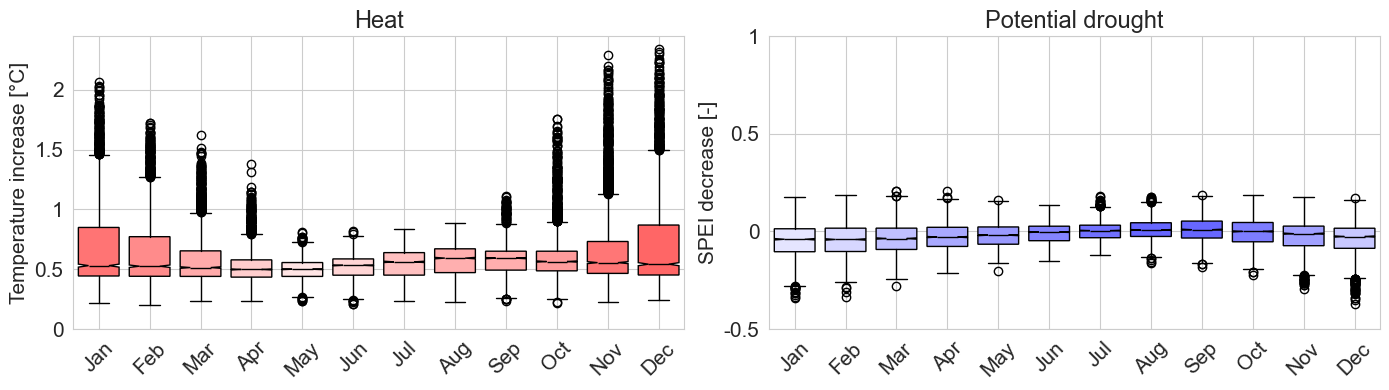

In [6]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1,2,figsize = (14,4))
    boxplot([tas_intensity_df, spi_intensity_df], 
            ['attributed_tas', 'attributed_spi'], 
            axes,
            titles = ['Heat', 'Potential drought'], 
            yticks_multi = [[0,0.5,1,1.5,2], [-0.5,0,0.5,1]], 
            yticklabels_multi =  [[0,0.5,1,1.5,2],[-0.5,0,0.5,1]])
    fig.tight_layout()
    # Path(GRAPHICS_PAPER_APPENDIX_DIR / 'graphics').mkdir(parents = True, exist_ok = True)
    # plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'graphics' / 'intensity_yearly_cycle.pdf', dpi = 300)
    plt.show()

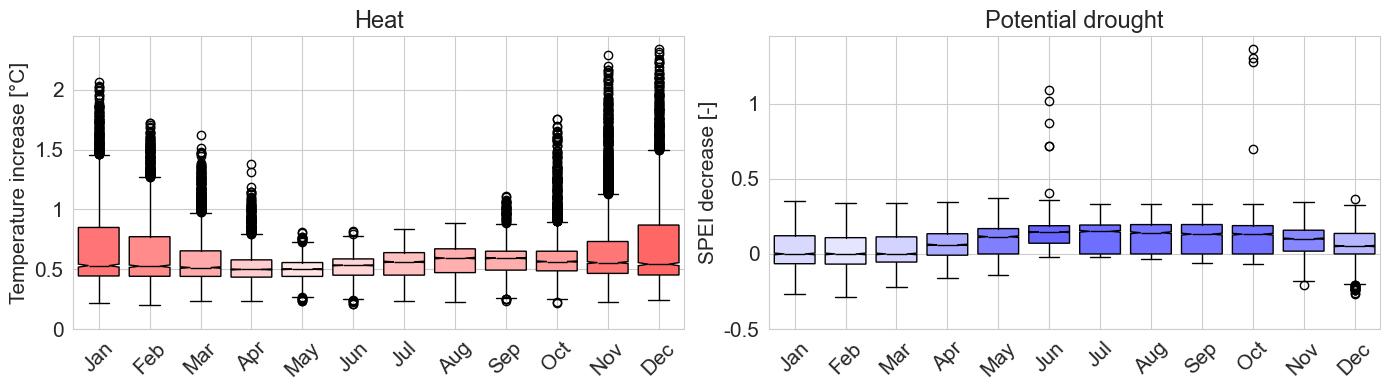

In [5]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1,2,figsize = (14,4))
    boxplot([tas_intensity_df, spei_intensity_df], 
            ['attributed_tas', 'attributed_spei'], 
            axes,
            titles = ['Heat', 'Potential drought'], 
            yticks_multi = [[0,0.5,1,1.5,2], [-0.5,0,0.5,1]], 
            yticklabels_multi =  [[0,0.5,1,1.5,2],[-0.5,0,0.5,1]])
    fig.tight_layout()
    Path(GRAPHICS_PAPER_APPENDIX_DIR / 'graphics').mkdir(parents = True, exist_ok = True)
    plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'graphics' / 'intensity_yearly_cycle.pdf', dpi = 300)
    plt.show()

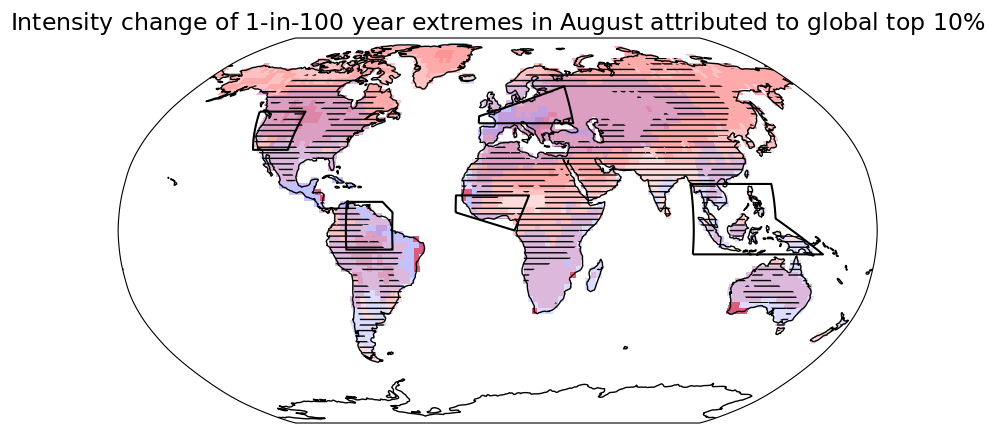

In [10]:
### add world plot  
sel_regions = [3, 17, 10, 21, 38]
fig, ax = plt.subplots(1,1,figsize = (10,5), subplot_kw={'projection': ccrs.Robinson()})
plot_2D_map(1, 7, 'August', ax, sel_regions, tas_bins = [0.2,0.4,0.6,0.8,1], tas_bin_labels = [0.2,0.4,0.6,0.8,1], spei_bins = [0,0.1,0.2,0.4,0.6], spei_bin_labels = [-0.4,-0.2,0,0.2,0.4,0.6])
plt.show()


### Generate intensity plots across season 

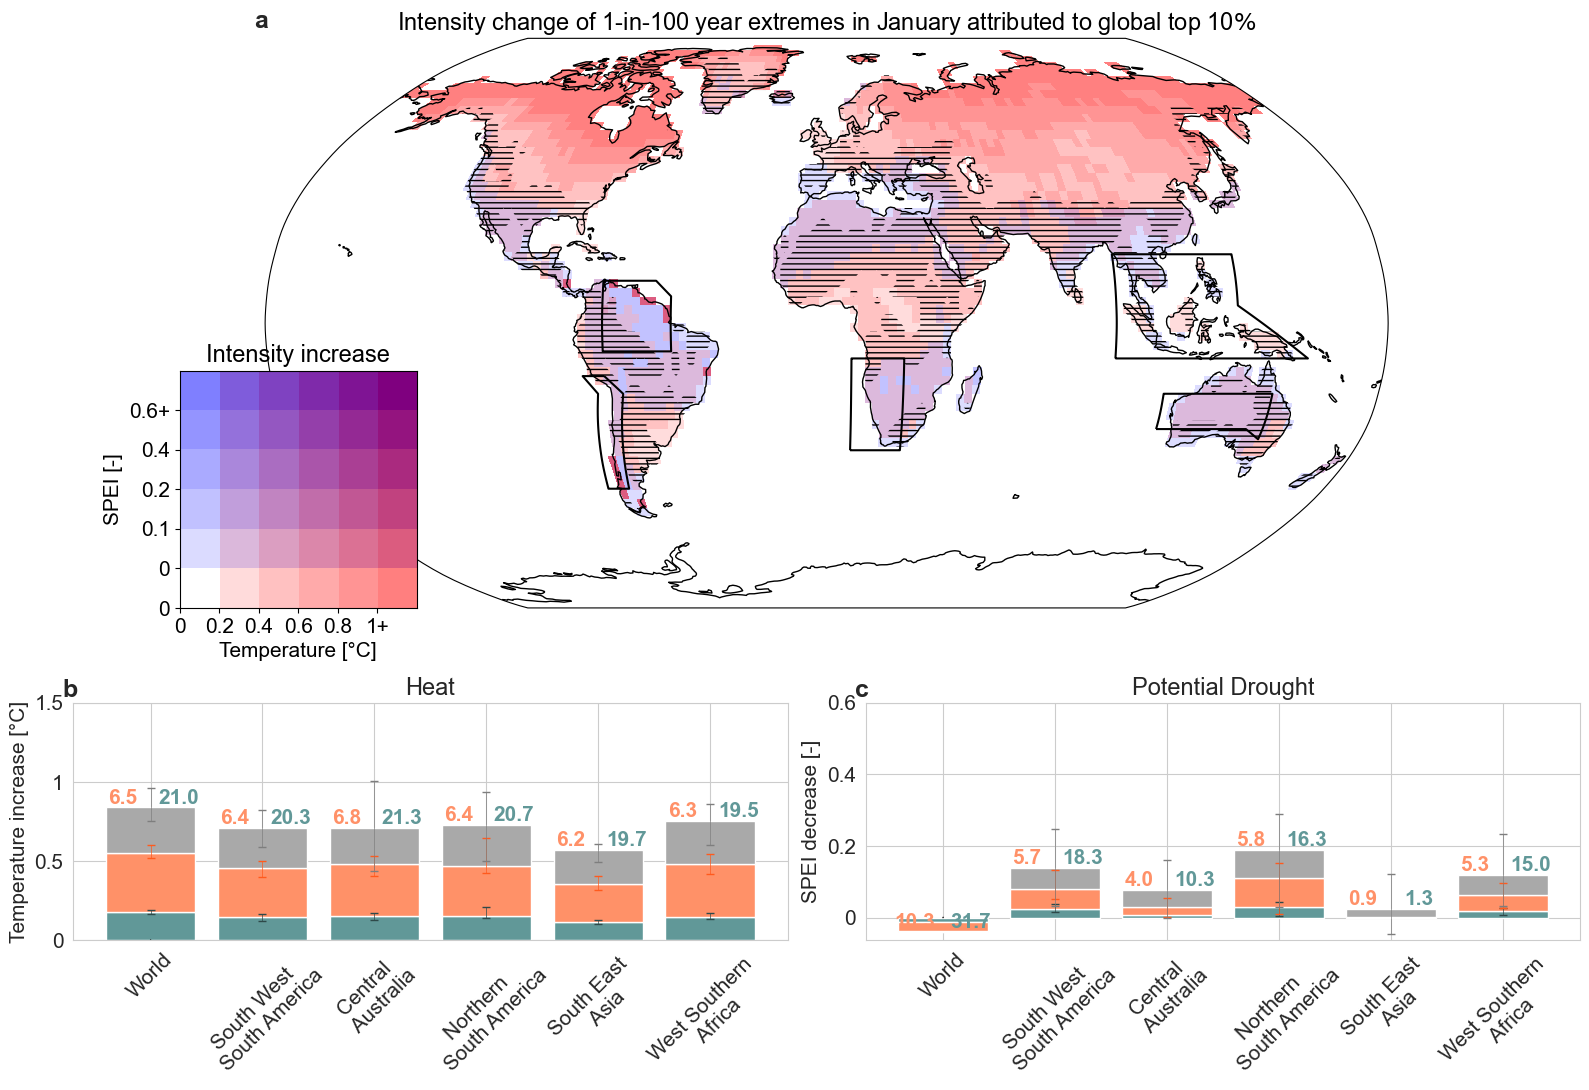

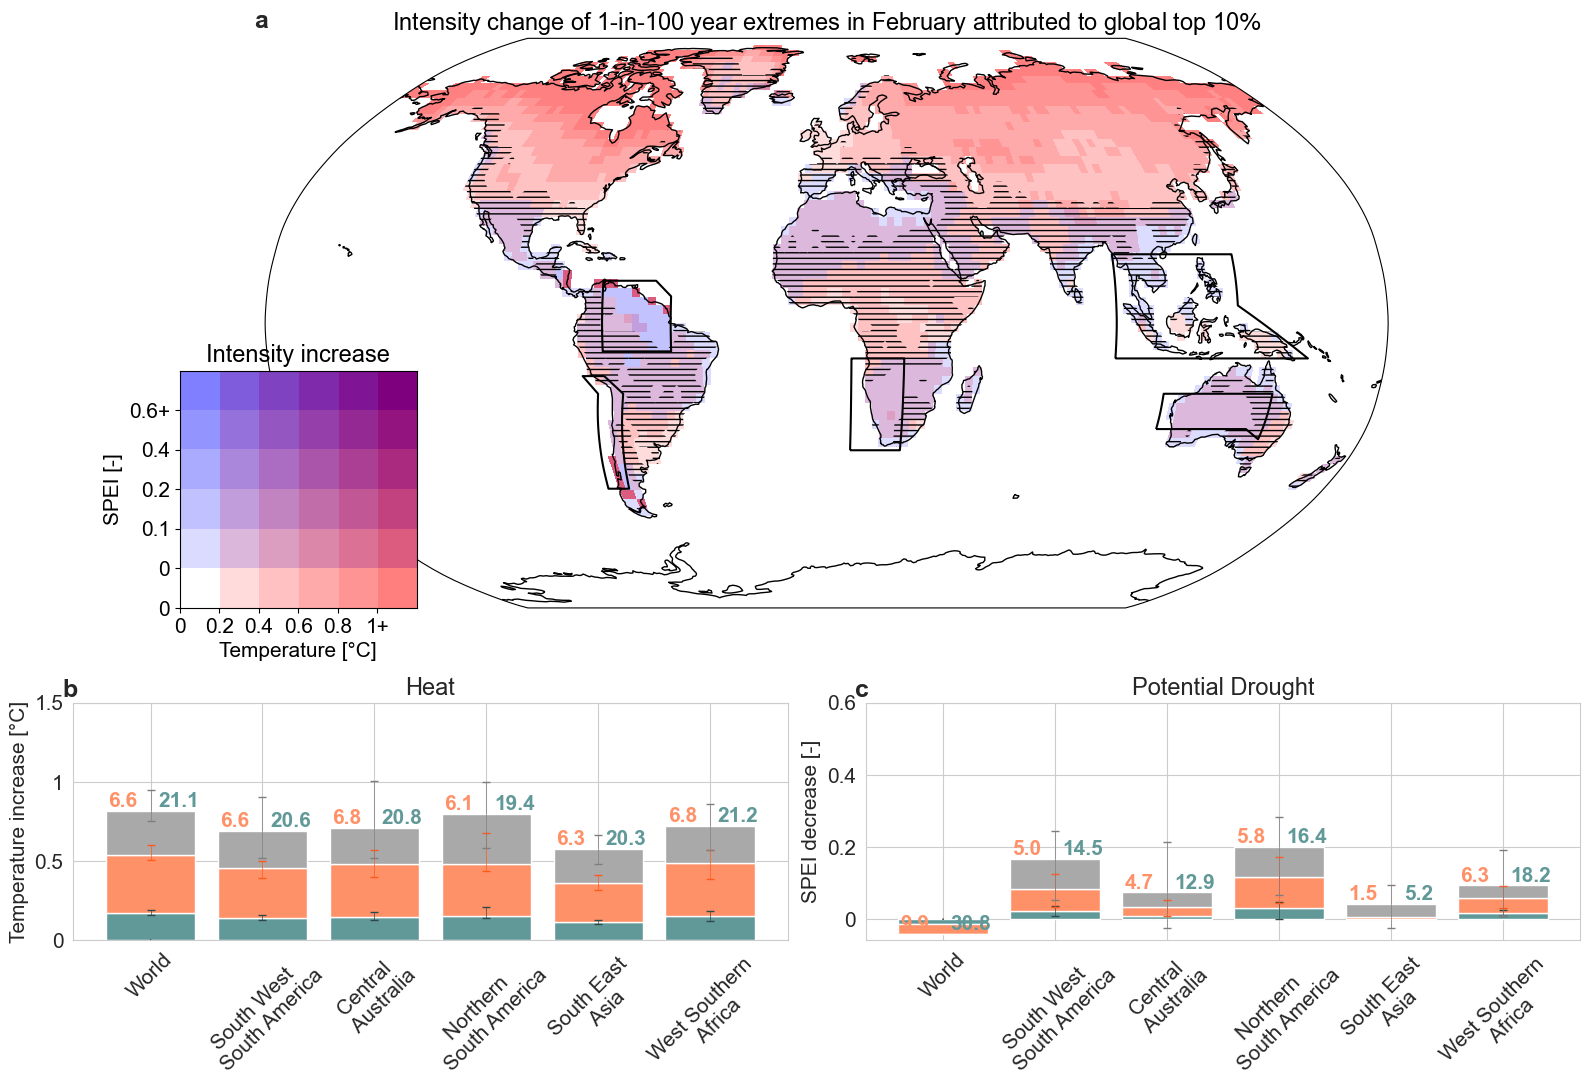

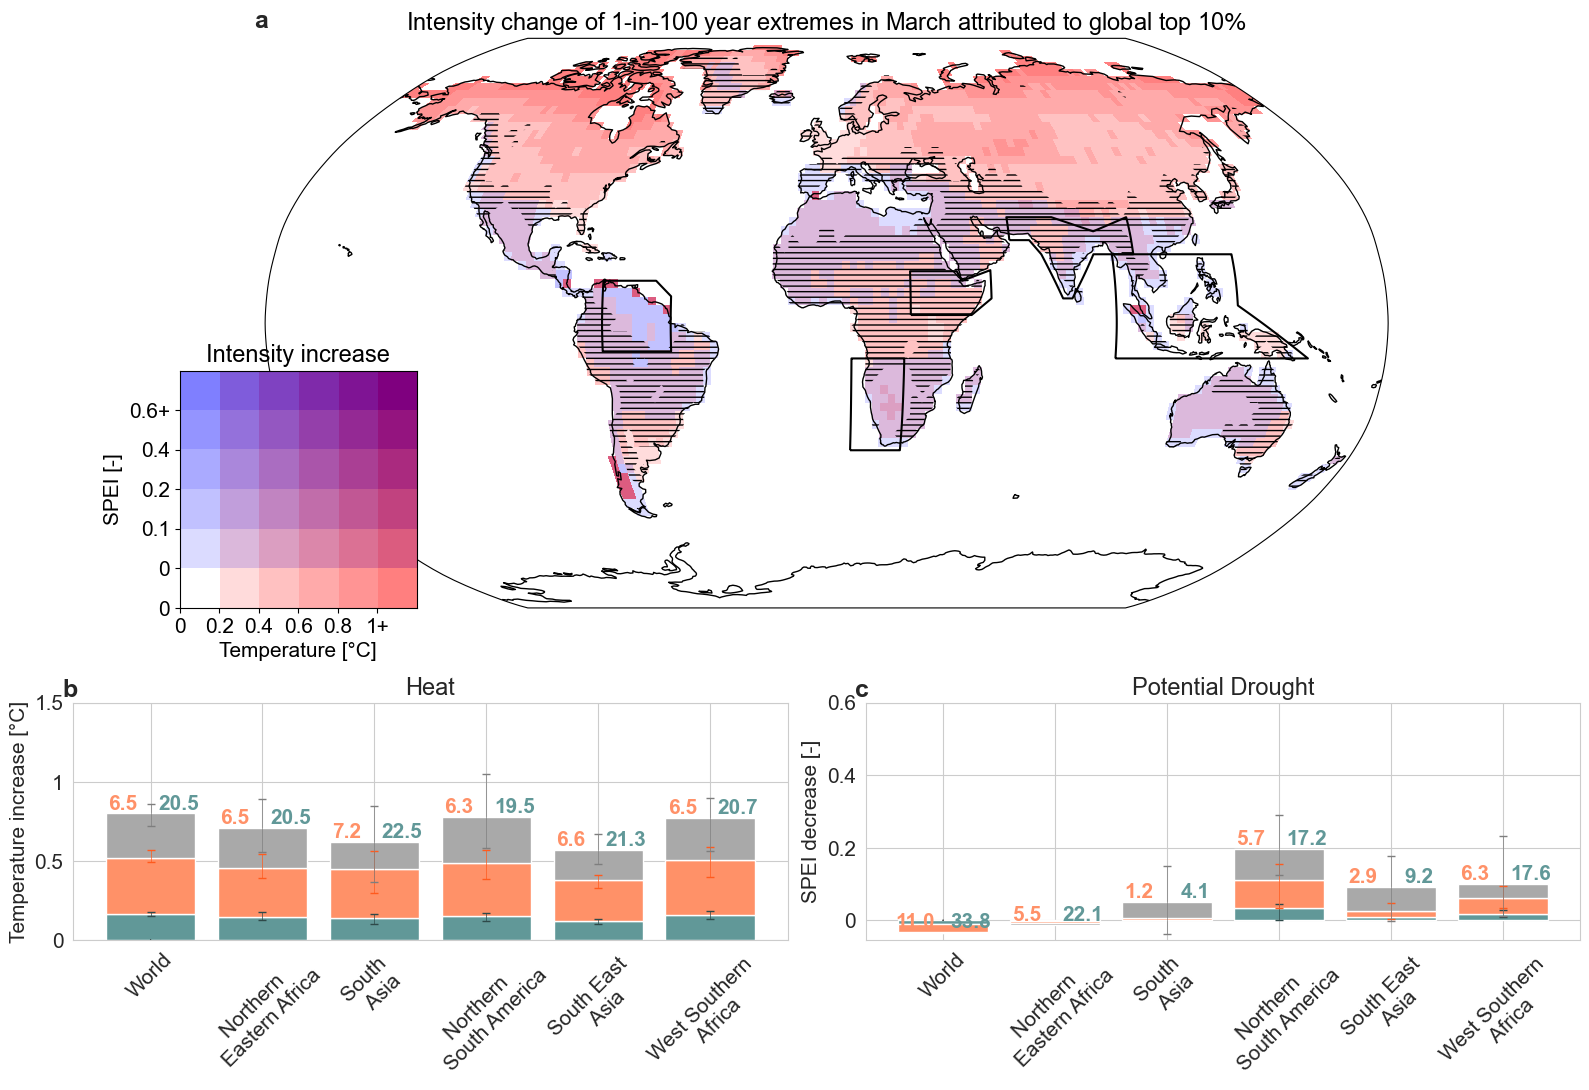

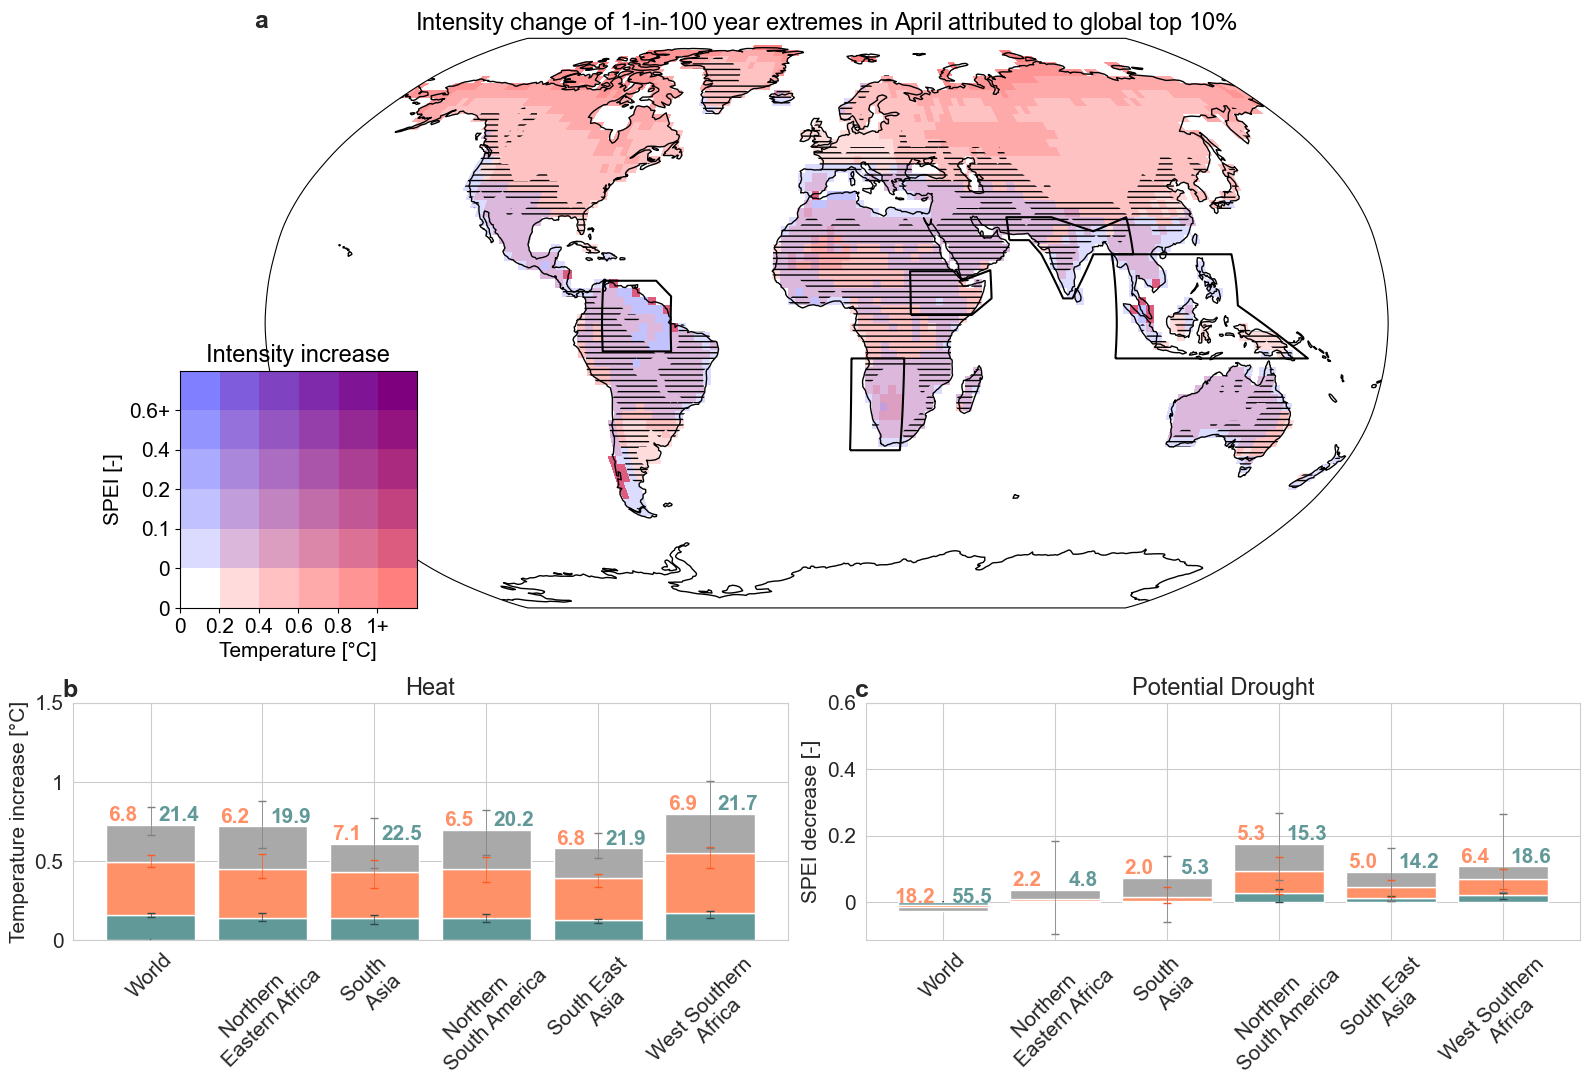

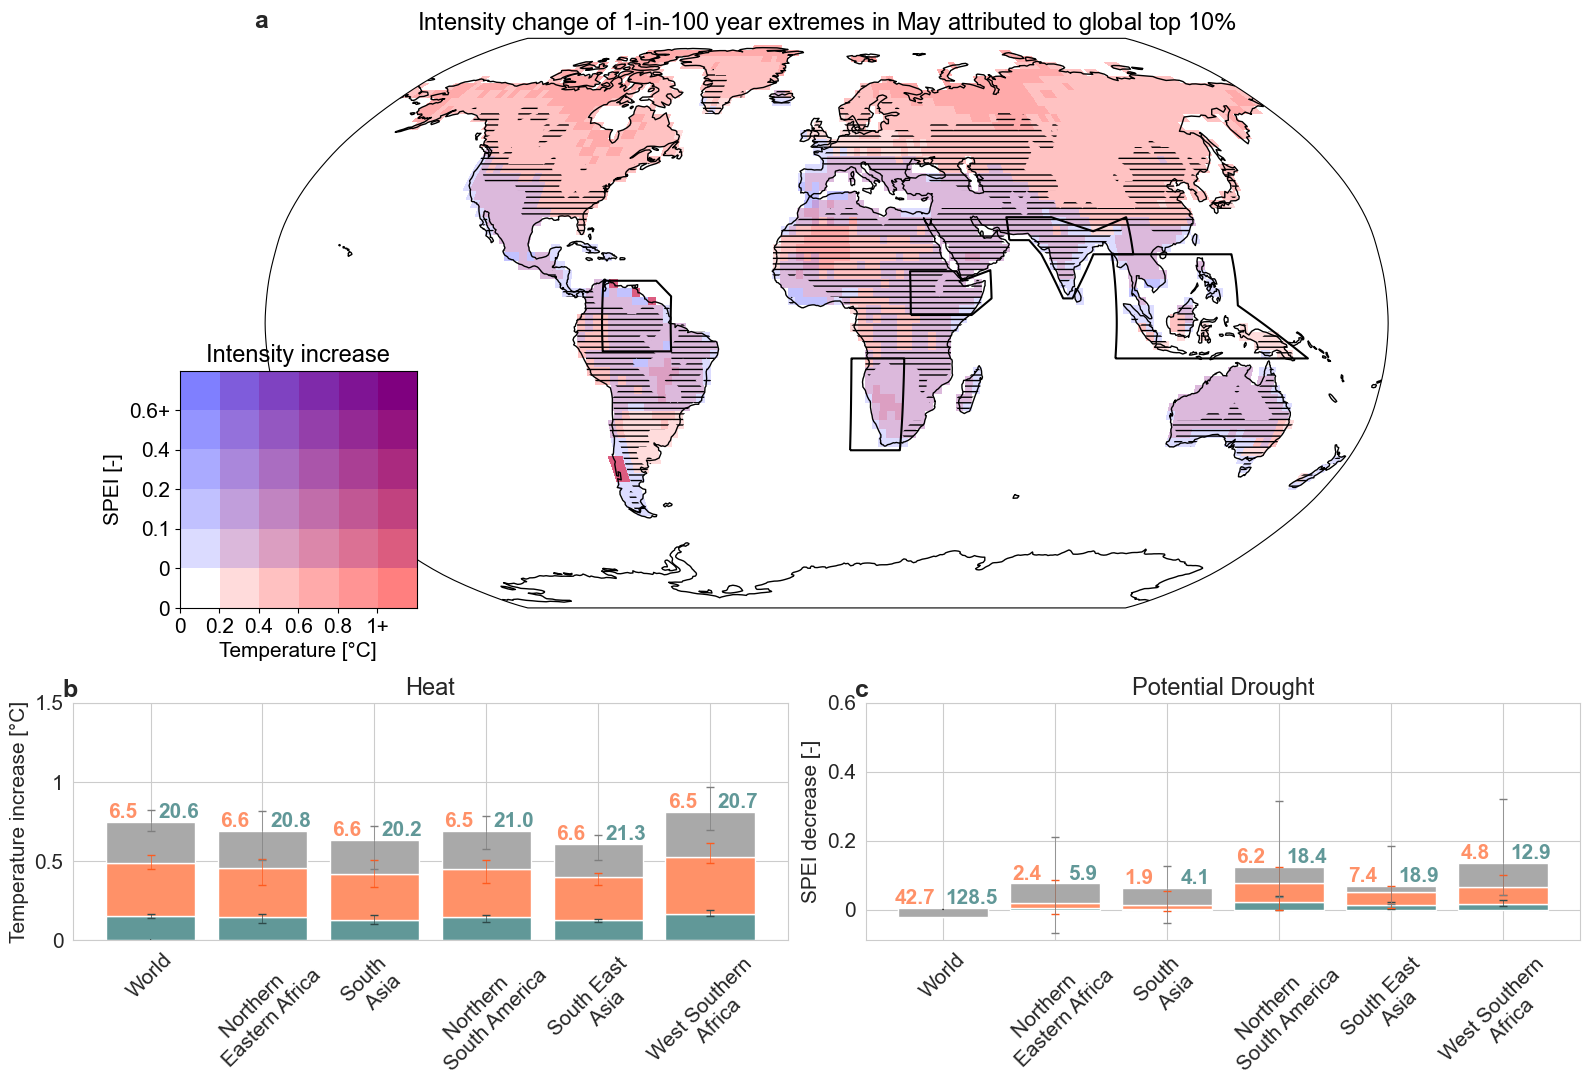

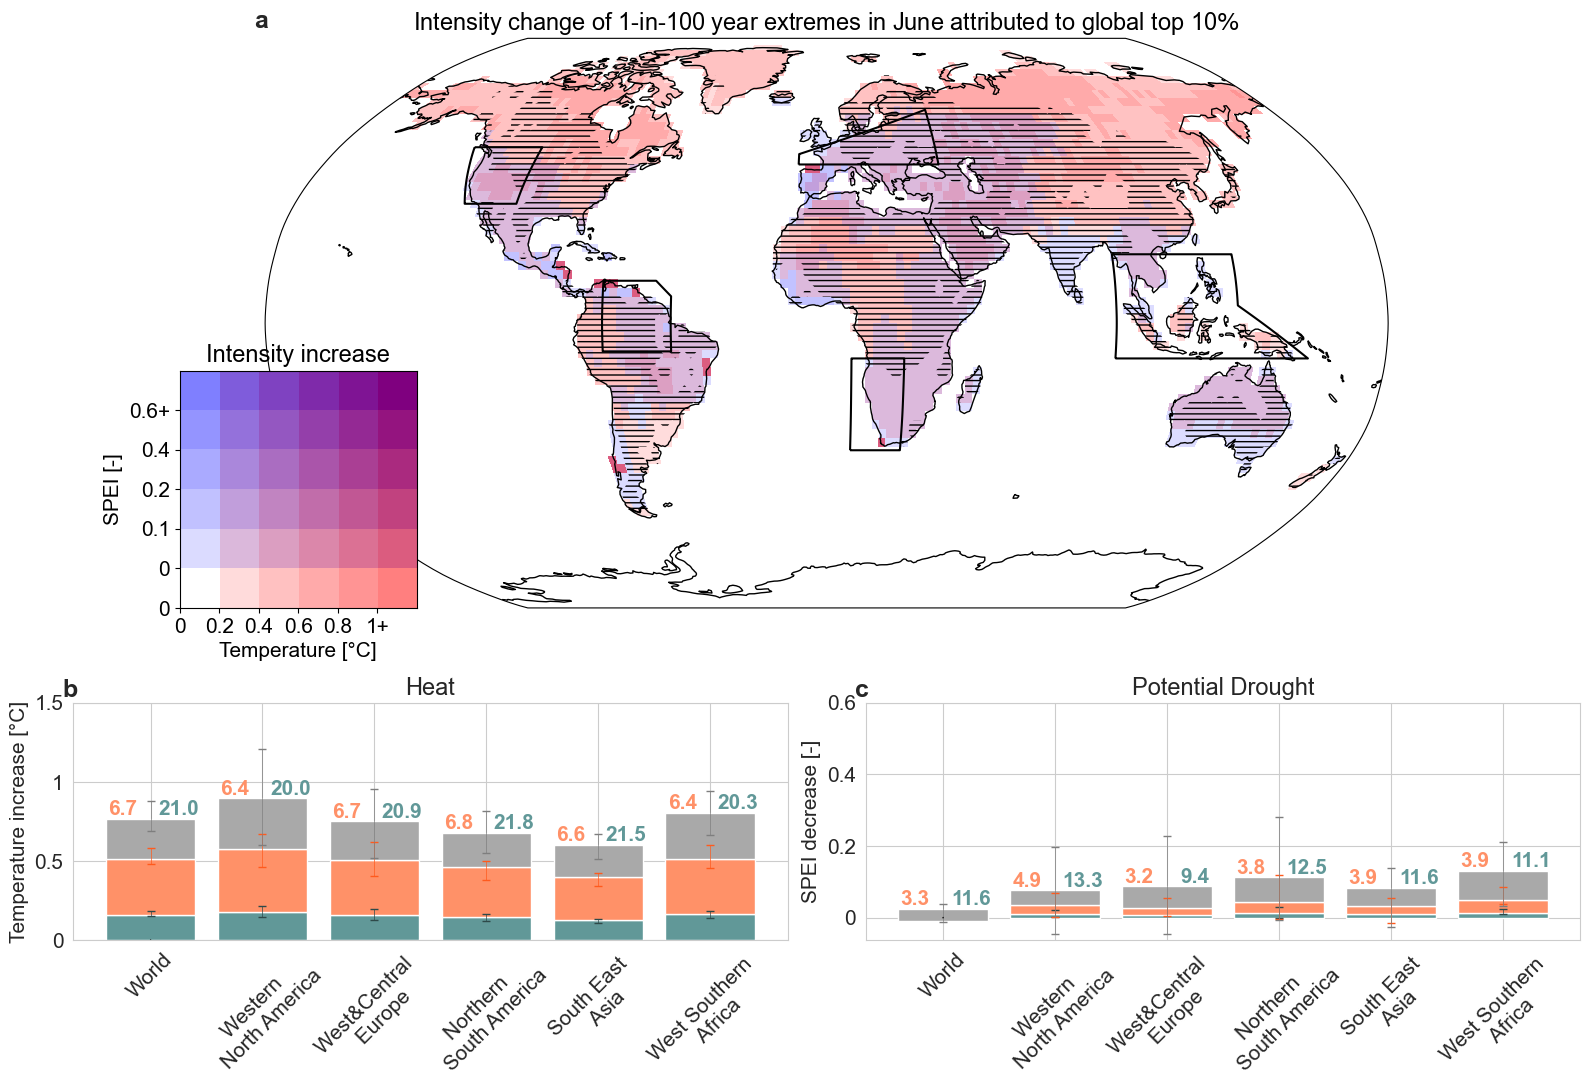

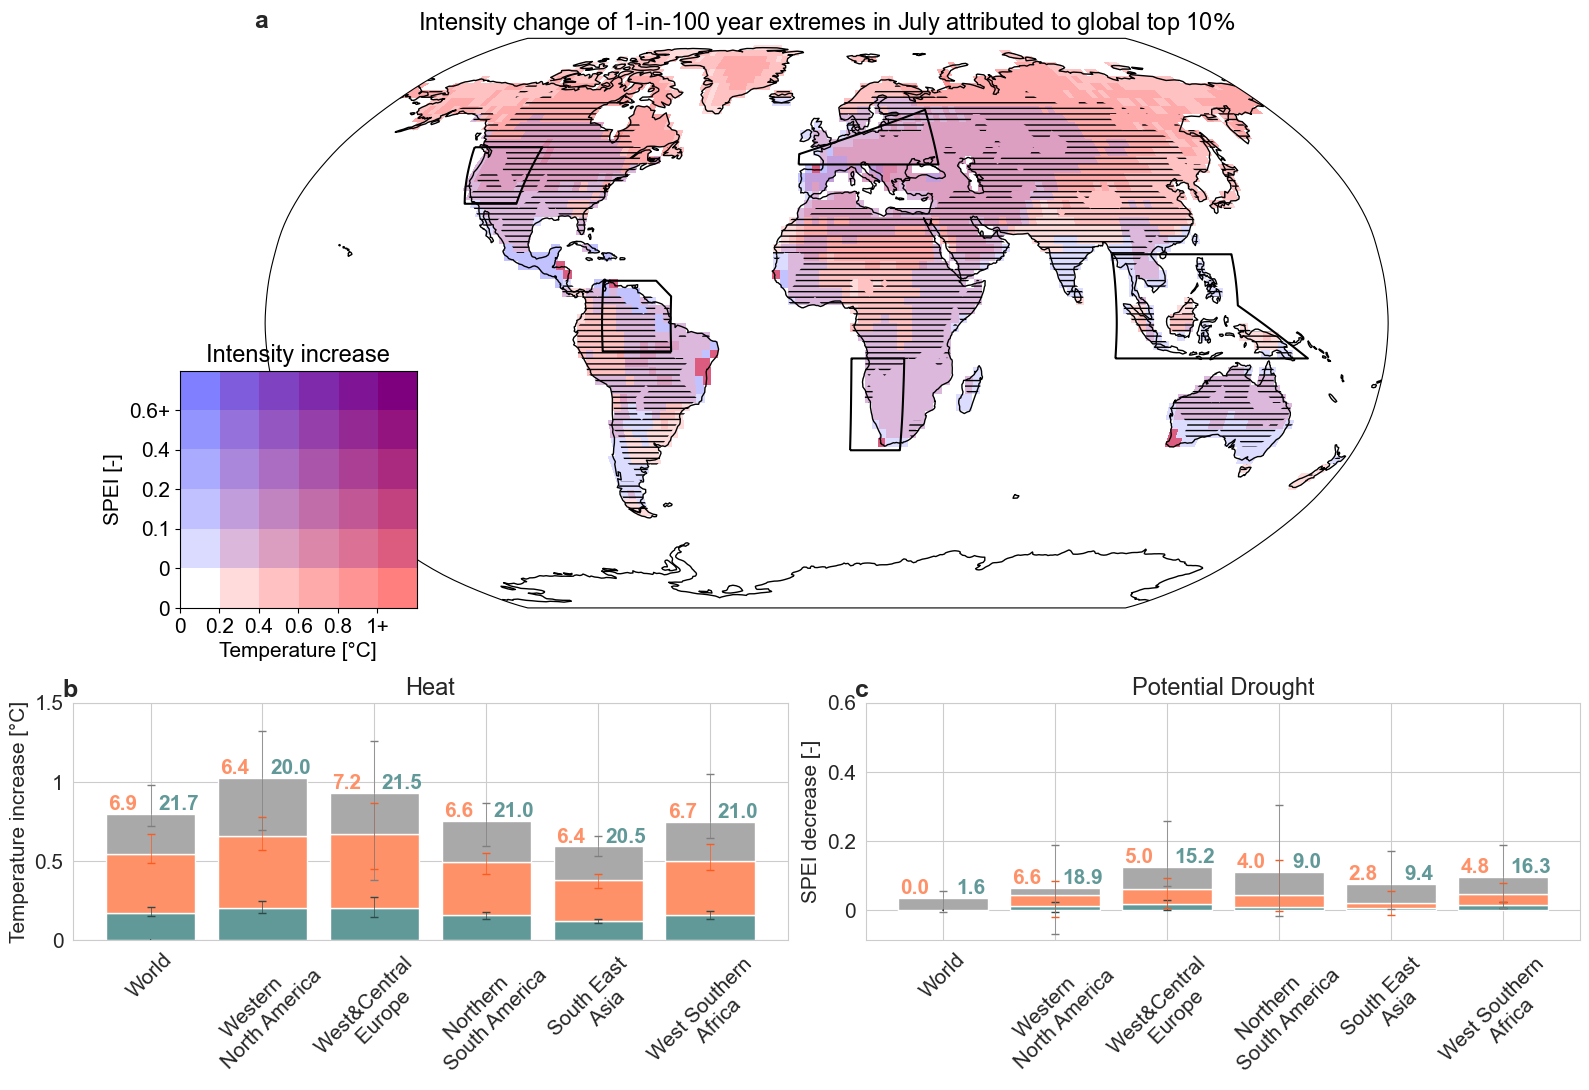

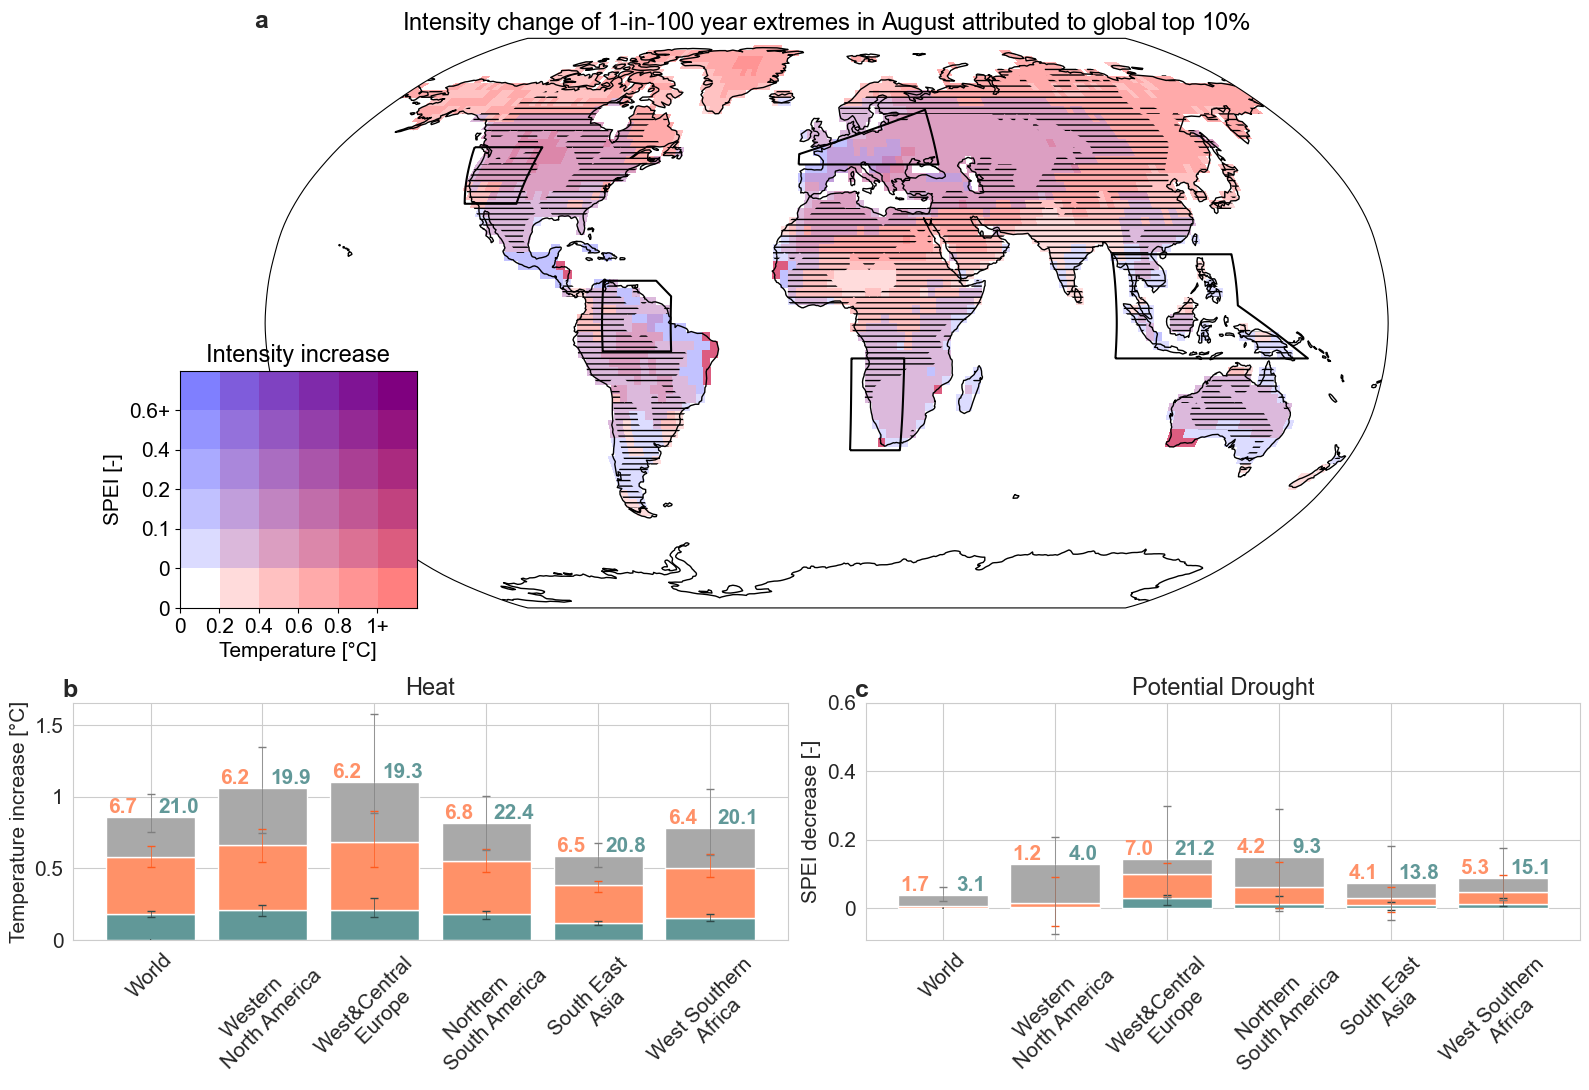

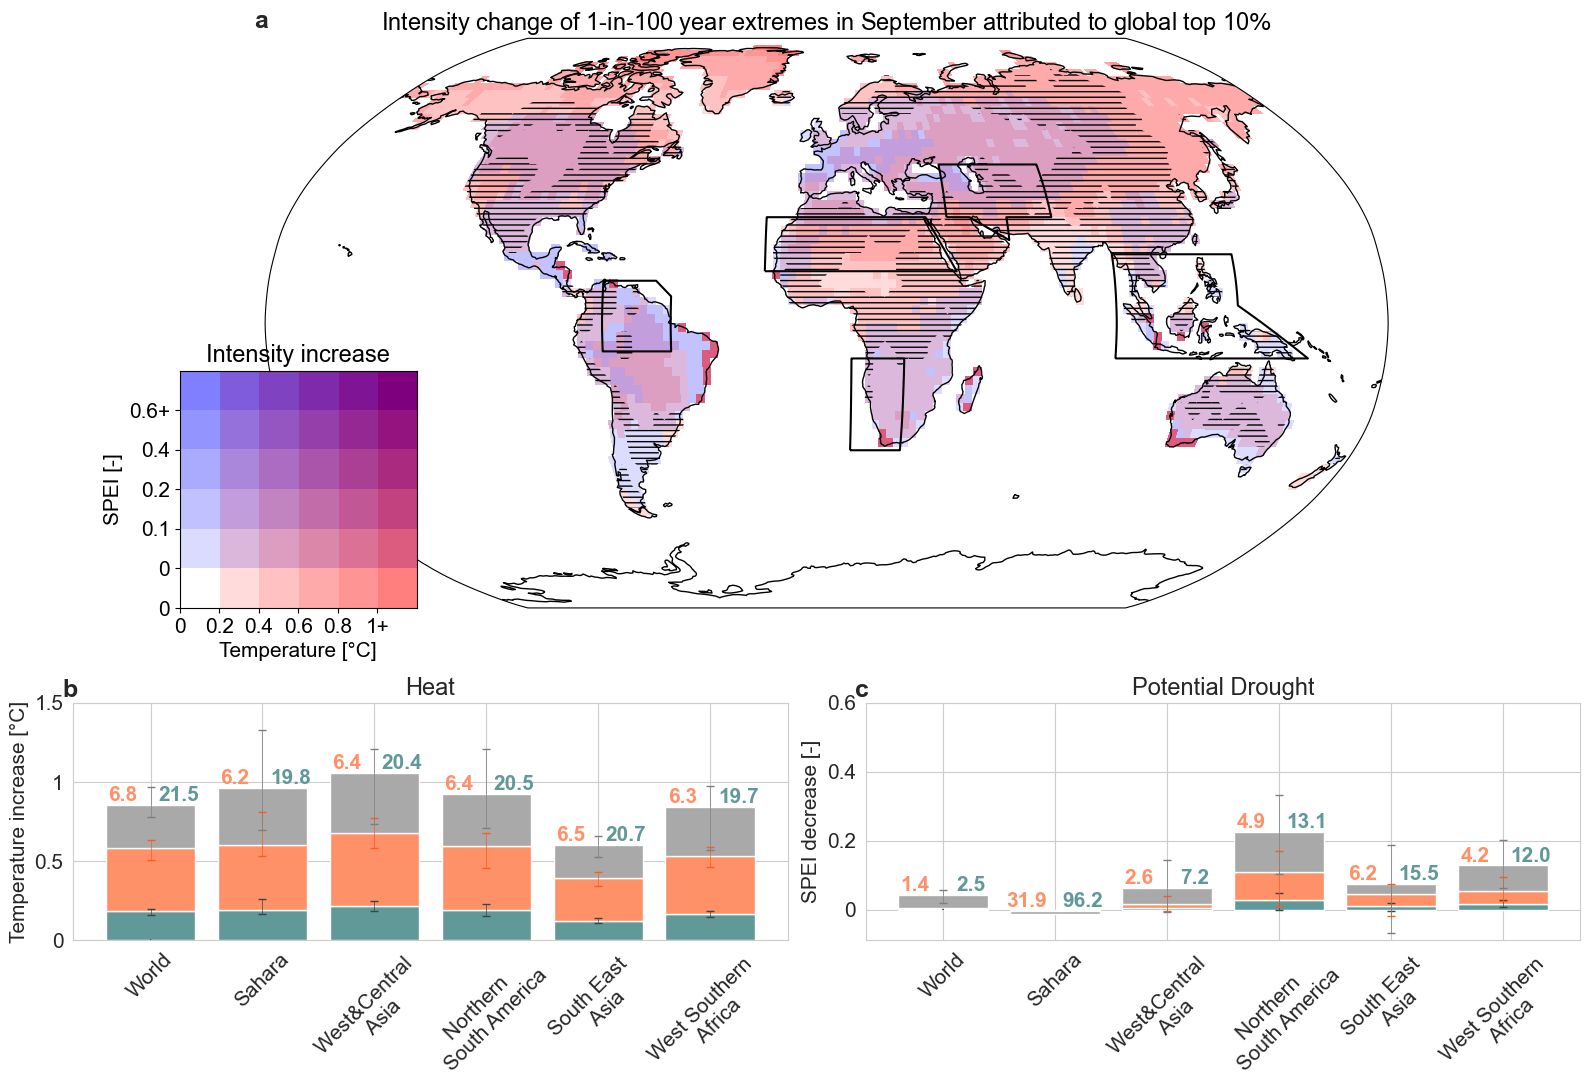

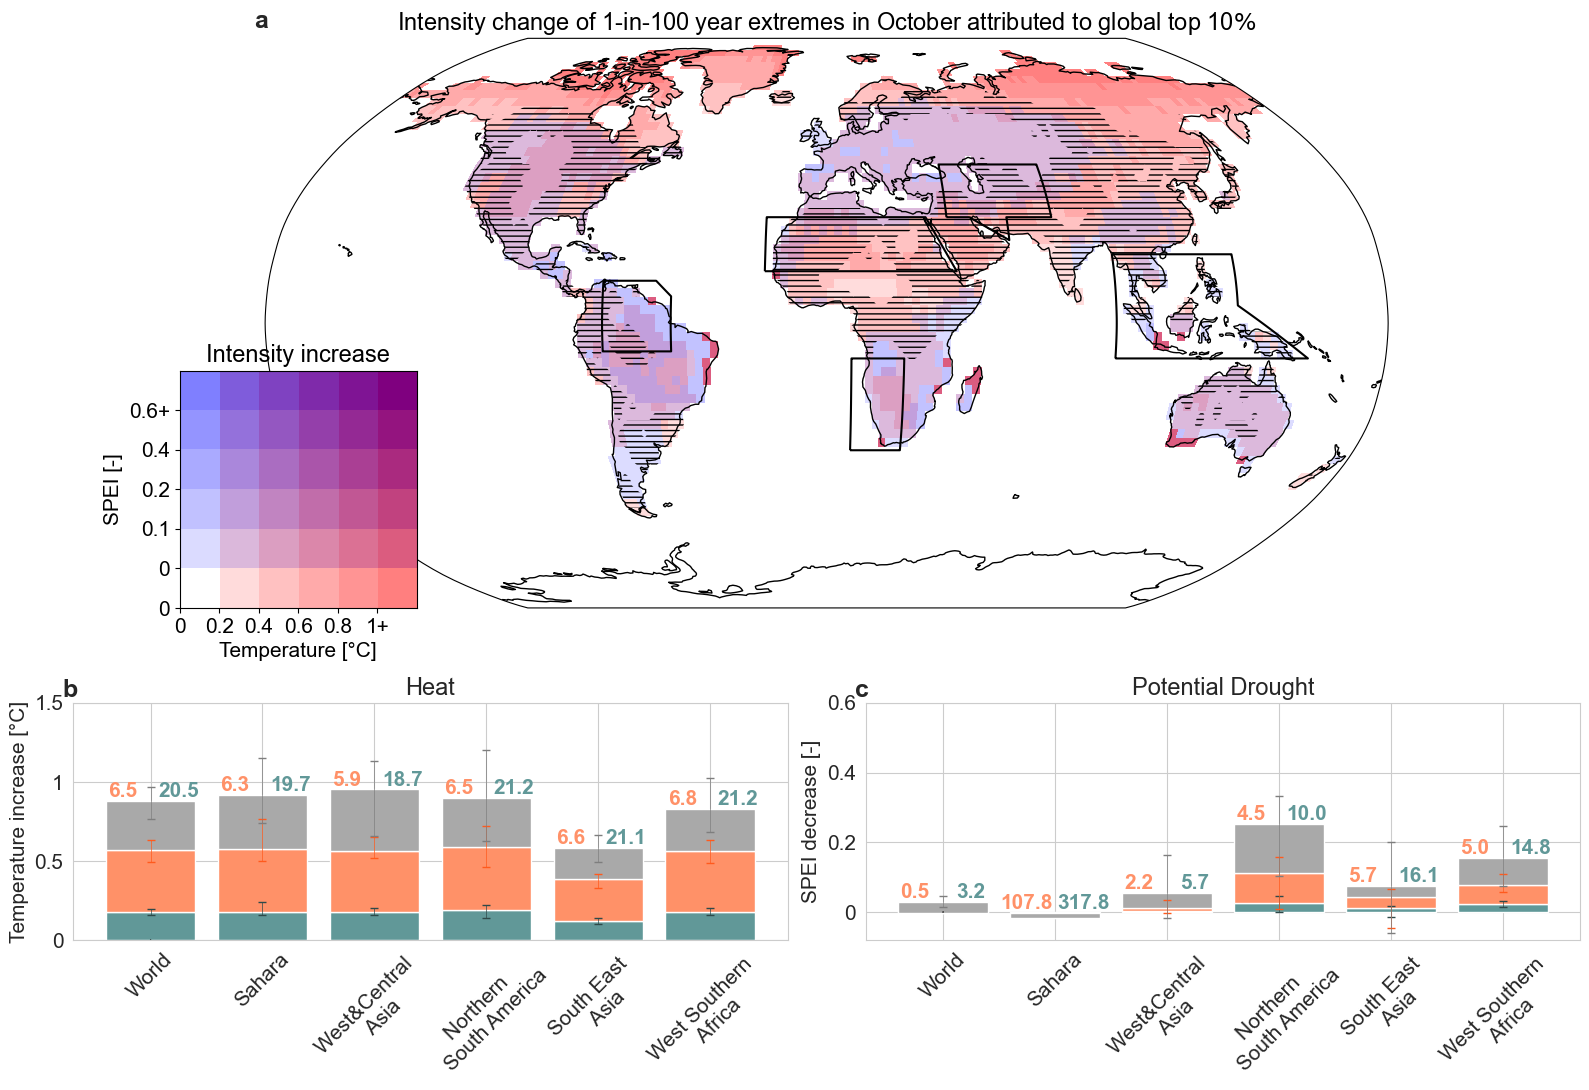

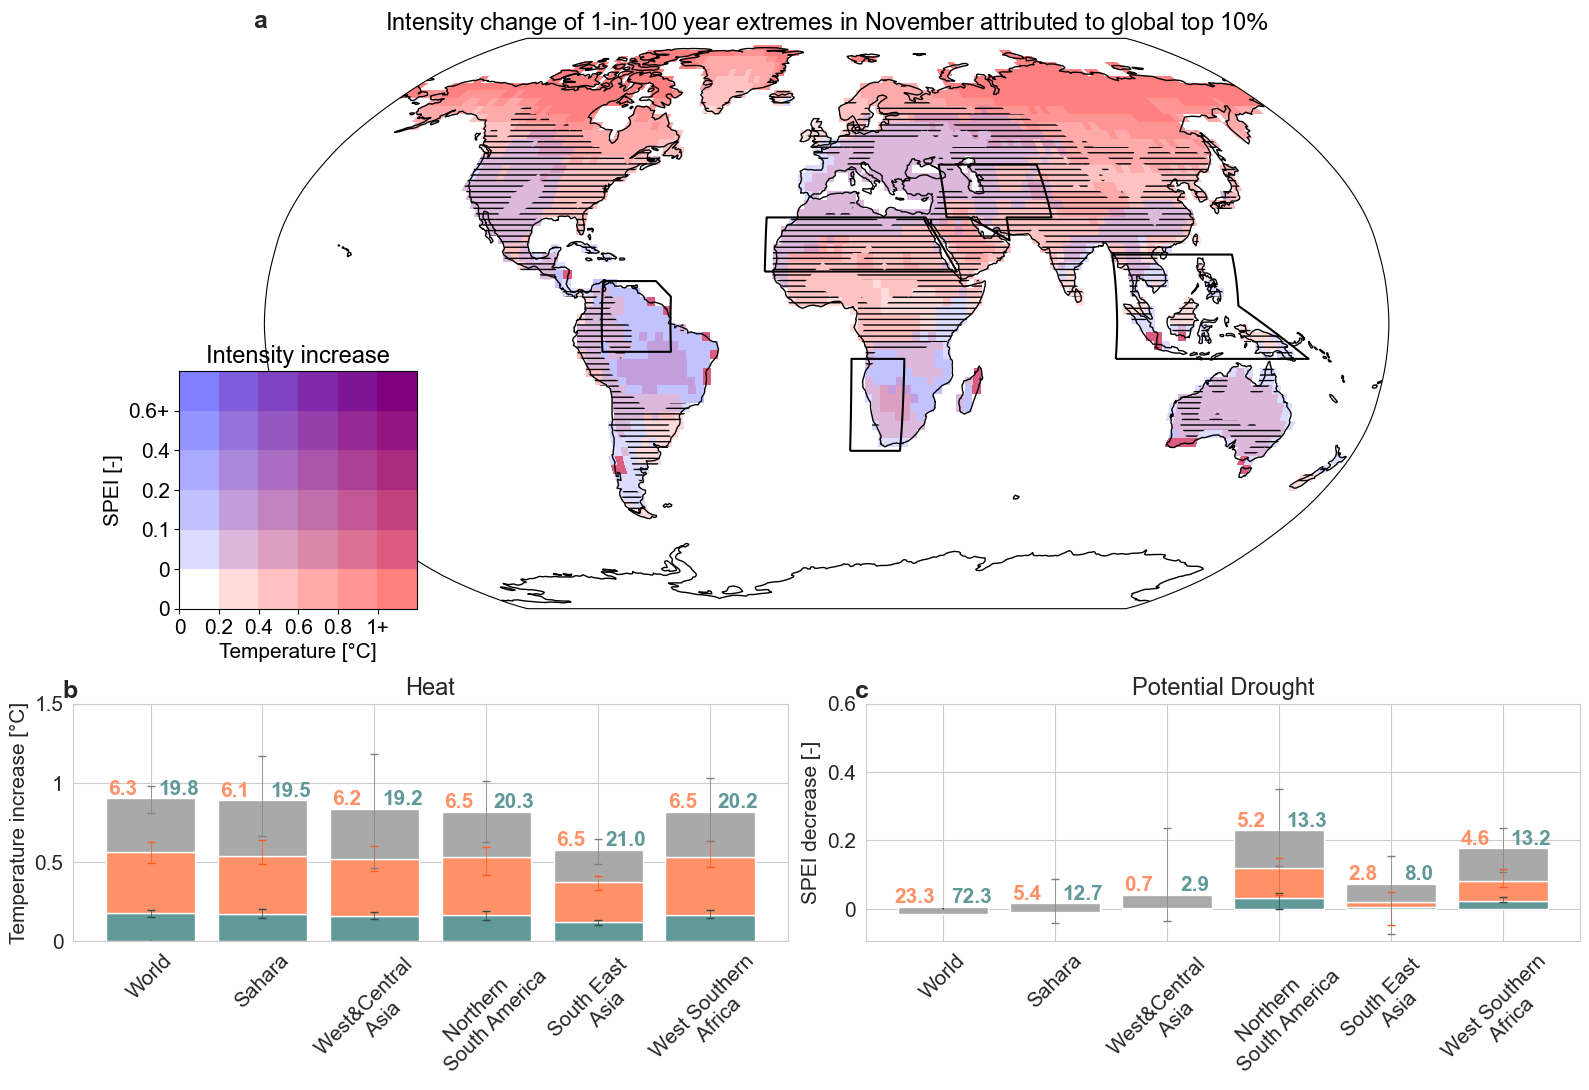

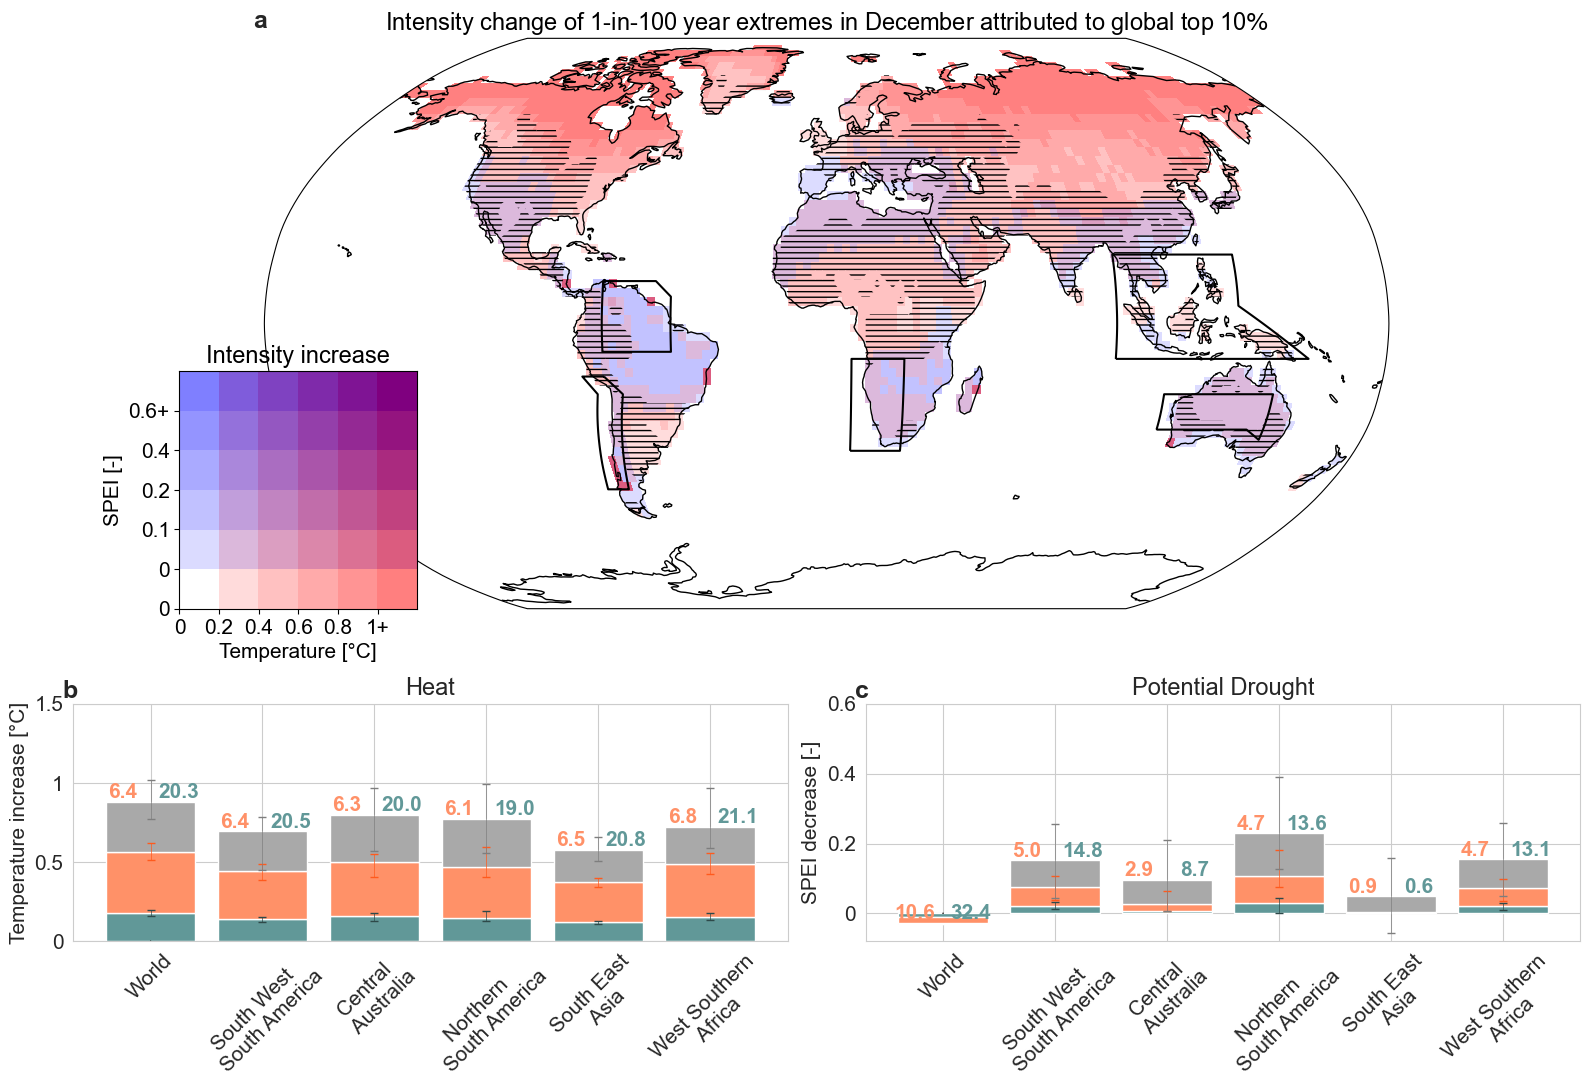

In [12]:
month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

sel_regions_all = [[13, 40, 10, 38, 25],
               [13, 40, 10, 38, 25],
               [23, 37,  10, 38, 25], 
               [23, 37,  10, 38, 25], 
               [23, 37,  10, 38, 25], 
               [3, 17, 10, 38, 25], 
               [3, 17, 10, 38, 25], 
               [3, 17, 10, 38, 25], 
               [20, 32, 10, 38, 25], 
               [20, 32, 10, 38, 25], 
               [20, 32, 10, 38, 25], 
               [13, 40, 10, 38, 25] 
               ]
sel_regions_names_all = [[ar6[region].name for region in sel_region] for sel_region in sel_regions_all]
region_names_sep_all = [['South West \n South America', 'Central \n Australia', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['South West \n South America', 'Central \n Australia', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Northern \n Eastern Africa', 'South \n Asia', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Northern \n Eastern Africa', 'South \n Asia', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Northern \n Eastern Africa', 'South \n Asia', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Western \n North America', 'West&Central \n Europe', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Western \n North America', 'West&Central \n Europe', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Western \n North America', 'West&Central \n Europe', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Sahara', 'West&Central \n Asia', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Sahara', 'West&Central \n Asia', 'Northern \n South America', 'South East \n Asia', 'West Southern \n Africa'],
                    ['Sahara', 'West&Central \n Asia', 'Northern \n South America', 'South East \n Asia', 'West Southern\n Africa'],
                    ['South West \n South America', 'Central \n Australia', 'Northern \n South America', 'South East\n Asia', 'West Southern\n Africa']
                    ]

for m in range(12):
        sel_regions = sel_regions_all[m]
        n_regions = len(sel_regions)
        region_names = sel_regions_names_all[m]
        region_names_sep = region_names_sep_all[m]
        m_name = month_name[m]
        i_quantile = 1

        axes = []
        
        fig = plt.figure(figsize= (16,11))
        gs = GridSpec(6, 6, figure=fig)
        
        ax = fig.add_subplot(gs[:4, :], projection=ccrs.Robinson())
        cbar_ax = fig.add_subplot(gs[2:4, :2])
        plot_2D_map(i_quantile = i_quantile, 
                        m = m, 
                        m_name = m_name,
                        ax = ax,
                        sel_regions = sel_regions,
                        tas_bins = [0.2,0.4,0.6,0.8,1],
                        tas_bin_labels = [0.2,0.4,0.6,0.8,1],
                        spei_bins = [0,0.1,0.2,0.4,0.6],
                        spei_bin_labels = [0,0.1,0.2,0.4,0.6]
        )

        color_palette_2D_plot(ax = cbar_ax, 
                        tas_bins = [0.2,0.4,0.6,0.8,1], 
                        spei_bins = [1, 5, 10, 20, 30],
                        tas_bin_labels = ['0.2','0.4','0.6','0.8','1+'], 
                        spei_bin_labels = ['0','0.1','0.2','0.4','0.6+']
        )
        axes.append(ax)
        
        with sns.axes_style('whitegrid'):        
                ax = fig.add_subplot(gs[4:, :3])
                regional_bargraph_plot(tas_intensity_df, 
                                i_quantile = i_quantile, 
                                m = m, 
                                sel_var = 'tas', 
                                sel_regions = sel_regions, 
                                ylabel = 'Temperature increase [°C]', 
                                yticks = [0,0.5,1,1.5], 
                                yticklabels  = [0,0.5,1,1.5], 
                                xticks = np.arange(len(sel_regions)), 
                                xticklabels = region_names_sep,
                                title = 'Heat',
                                ax =  ax)
                axes.append(ax)
                
                ax = fig.add_subplot(gs[4:, 3:])
                regional_bargraph_plot(-spi_intensity_df, 
                                i_quantile = i_quantile, 
                                m = m, 
                                sel_var = 'spi', 
                                sel_regions = sel_regions, 
                                ylabel = 'SPEI decrease [-]', 
                                yticks = [0,0.2,0.4,0.6], 
                                yticklabels  = [0,0.2,0.4,0.6], 
                                xticks = np.arange(len(sel_regions)), 
                                xticklabels = region_names_sep,
                                title = 'Potential Drought',
                                ax =  ax)
                axes.append(ax)
                
                lettering = ['a', 'b', 'c', 'd']
                
                # axes[0].text(-0.8, 38,'a',fontsize=fontsize_large+1, fontweight='bold', va='top')
                # axes[1].text(0, 0,'b',transform=axes[0].transAxes,fontsize=fontsize_large+1, fontweight='bold', va='top')
                
                # axes[0].text(0.5,0.5,'a', transform=axes[i].transAxes,fontsize=fontsize_large+1, fontweight='bold', va='top')
                xs = [-0.01] + [-0.015]*2
                ys = [1.05] + [1.1]*2
                for i in range(3):
                        axes[i].text(xs[i], ys[i], lettering[i], transform=axes[i].transAxes, fontsize=fontsize_large+1, fontweight='bold', va='top')
                 
                fig.tight_layout()
                # Path(GRAPHICS_PAPER_APPENDIX_DIR / 'graphics').mkdir(parents=True, exist_ok=True)
                # plt.savefig(GRAPHICS_PAPER_APPENDIX_DIR / 'graphics' / f'intensity_grid-cell_extremes_{m_name}.pdf', bbox_inches = 'tight', dpi = 600)
                plt.show()